In [1]:
import scvelo as scv
import numpy as np  
import matplotlib.pyplot as plt

import anndata

import pandas as pd
import scprep

import sys
sys.path.append("..")


import cellpath as cp
import cellpath.visual as visual
import cellpath.benchmark as bmk 
import cellpath.de_analy as de


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

## Meta-cell construction

In [2]:
num_trajs = 4
include_all_cells = True
num_metacells = 400

In [3]:
# read in simulated dataset
adata = anndata.read_h5ad("../sim_data/Dyngen/two_batches_clust.h5ad")

In [4]:
cellpath_obj = cp.CellPath(adata = adata)
cellpath_obj.all_in_one(num_metacells = num_metacells, n_neighs = 10, pruning = False, num_trajs = num_trajs, insertion = include_all_cells, prop_insert = 0.05)

Already conducted clustering
Meta-cell constructed
Meta-cell level neighborhood graph constructed
cut off small paths and conduct quality control
selected path (starting_ending):
start_end:  22_236 , len:  31 newly covered: 31
start_end:  142_316 , len:  29 newly covered: 18
start_end:  162_98 , len:  27 newly covered: 11
start_end:  306_59 , len:  27 newly covered: 9
start_end:  22_107 , len:  30 newly covered: 3
start_end:  22_375 , len:  31 newly covered: 2
start_end:  22_242 , len:  29 newly covered: 3
start_end:  22_353 , len:  30 newly covered: 2
start_end:  22_69 , len:  29 newly covered: 2
start_end:  22_37 , len:  29 newly covered: 2
start_end:  22_86 , len:  29 newly covered: 2
start_end:  22_270 , len:  29 newly covered: 2
start_end:  22_64 , len:  26 newly covered: 4
start_end:  22_348 , len:  30 newly covered: 1
start_end:  22_47 , len:  27 newly covered: 3
Finished
number of cells: 1713
Cell-level pseudo-time inferred


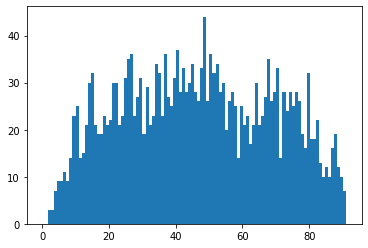

In [5]:
visual.weight_histogram(cellpath_obj, resolution = 100)

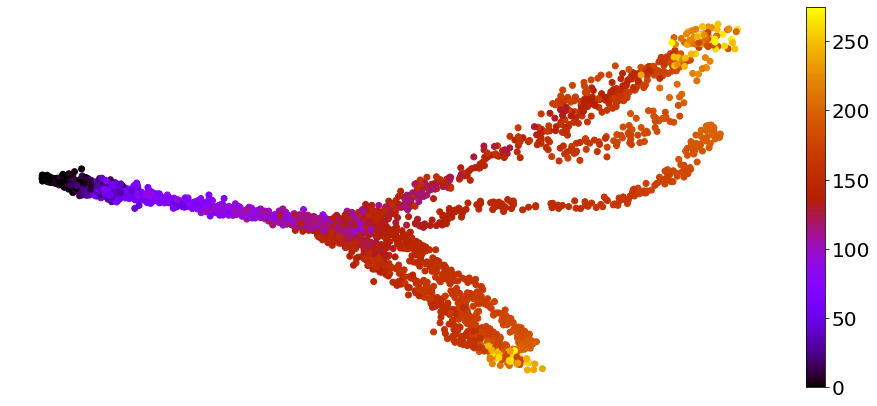

In [6]:
visual.plot_data(cellpath_obj, basis = "pca", figsize = (15,7), save_as = None)

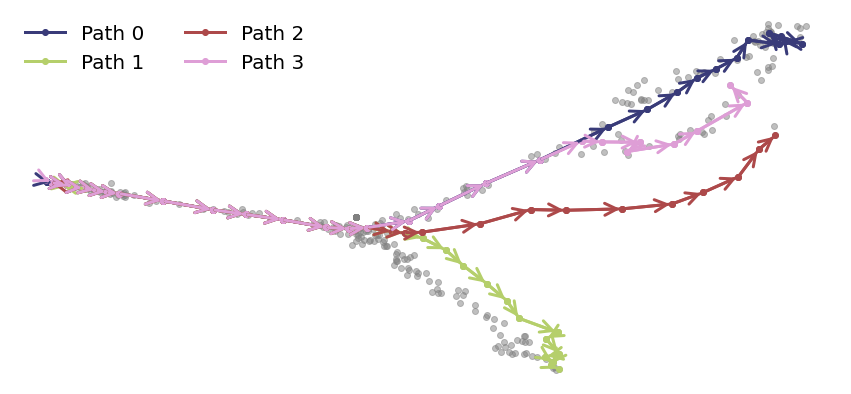

In [7]:
visual.meta_traj_visual(cellpath_obj, basis = "pca", trajs = num_trajs, figsize = (15,7), save_as = None, legend_pos = "upper left", axis = False)

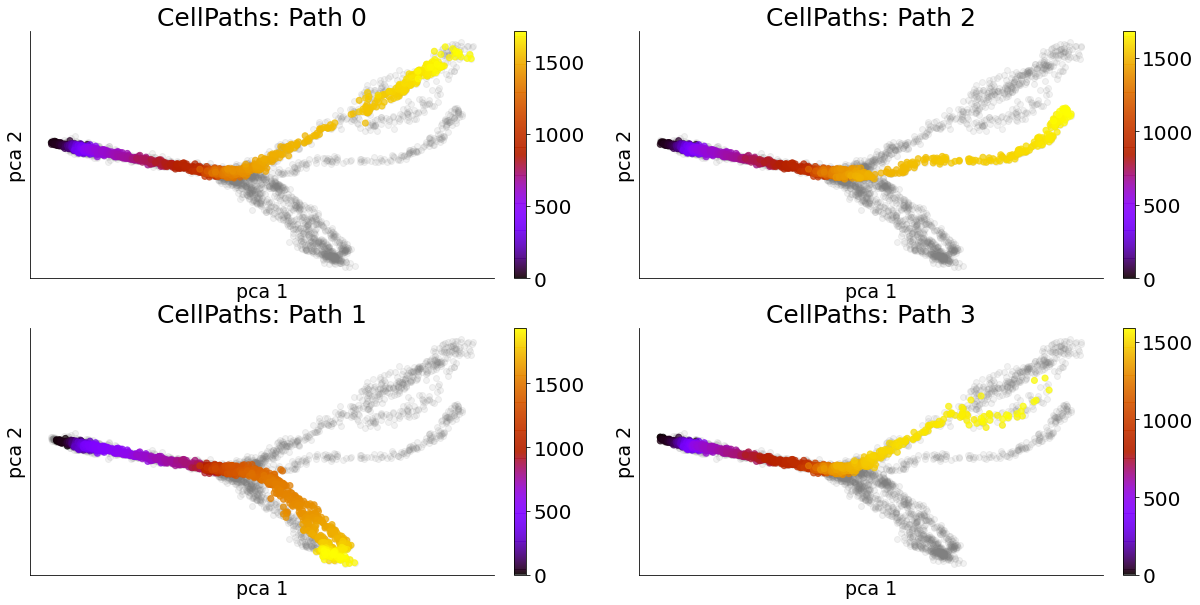

In [8]:
visual.first_order_approx_pt(cellpath_obj, basis = "pca", trajs = num_trajs, figsize = (20,10), save_as = None)

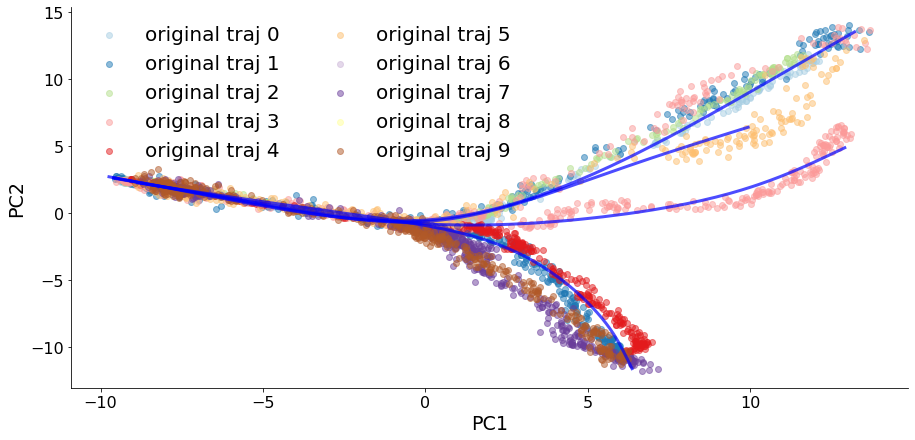

In [9]:
visual.traj_visual(cellpath_obj, trajs = num_trajs, figsize = (15,7), cmap = "Paired", save_as = None)

# Benchmark
## CellPaths
### Kendall-tau test


In [10]:
kt = bmk.cellpath_kt(cellpath_obj)

### Topology

In [11]:
f1 = bmk.f1_score(cellpath_obj = cellpath_obj, method="CellPath", trajs = num_trajs)

recovery

inferred trajectory: 0 jaccard: 0.19791666666666666
inferred trajectory: 1 jaccard: 0.21765913757700206
inferred trajectory: 2 jaccard: 0.24081632653061225
inferred trajectory: 3 jaccard: 0.16496700659868027
recovery value: 0.2053397843432403
relevence

ori trajectory: 1 jaccard: 0.19791666666666666
ori trajectory: 2 jaccard: 0.20379575237234523
ori trajectory: 3 jaccard: 0.19212962962962962
ori trajectory: 4 jaccard: 0.24081632653061225
ori trajectory: 5 jaccard: 0.21765913757700206
ori trajectory: 6 jaccard: 0.0787746170678337
ori trajectory: 8 jaccard: 0.06370243693886277
ori trajectory: 10 jaccard: 0.06426966292134831
relevence value: 0.15738302871303758


In [12]:
bmk_belongings = bmk.purity_count(cellpath_obj = cellpath_obj, method = "CellPath", trajs = num_trajs)
entro = bmk.average_entropy(bmk_belongings)
entro

1.9652354248454145

### Slingshot

In [13]:
adata = anndata.read_h5ad("../sim_data/Dyngen/two_batches.h5ad")
X_pca = adata.obsm['X_pca']

n_clusters = 10
init = "k-means++"
n_init = 10
max_iter = 300
tol = 0.0001
kmeans = KMeans(n_clusters, init, n_init, max_iter, tol)
groups = kmeans.fit_predict(X_pca)
meta_data = adata.obs
meta_data['groups'] = groups

Text(0.5, 1.0, 'slingshot clusters')

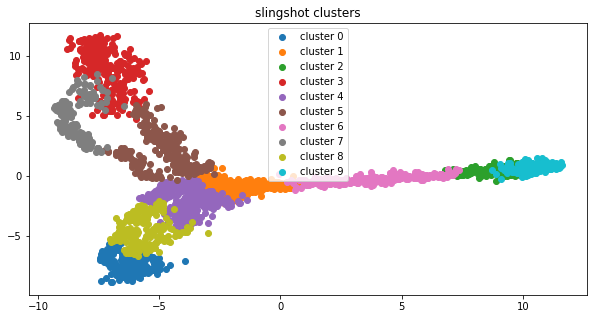

In [14]:
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot()
c_range = [eval(x) if isinstance(x, str) else x for x in adata.obs['sim_time']]
clusters = int(np.max(groups)+1)
for i in range(clusters):
    sub_cells = np.where(groups == i)[0]
    progression = ax.scatter(X_pca[sub_cells,0], X_pca[sub_cells,1], cmap = plt.get_cmap('Pastel1'))
    # progression = ax.scatter(X_umap[sub_cells,0], X_umap[sub_cells,1], cmap = plt.get_cmap('Pastel1'))

ax.legend(['cluster '+ str(i) for i in range(clusters)])
ax.set_title("slingshot clusters")
# fig.savefig("./syn_results/dataset1/slingshot_clust.pdf")

In [19]:
X_pca_df = pd.DataFrame(index=[str(x) for x in range(X_pca.shape[0])], columns= np.arange(2), data = X_pca[:,0:2])
# scprep.run.install_bioconductor('slingshot')
results = scprep.run.Slingshot(X_pca_df, meta_data['groups'], start_cluster = 9)

R[write to console]: Using full covariance matrix


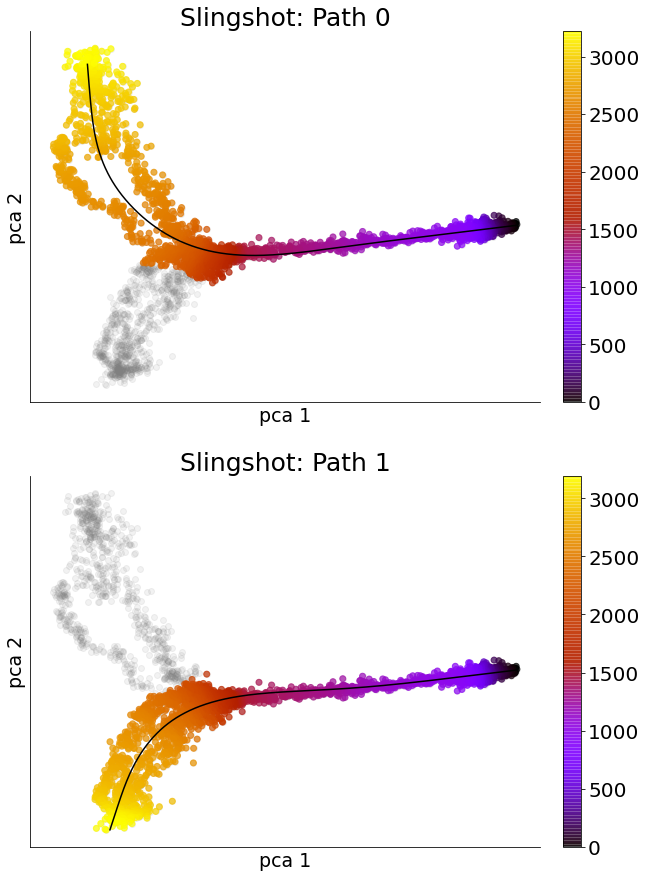

In [20]:
kt_slingshot = visual.slingshot_visual(adata,  results, basis= "pca", figsize=(10,15), save_as = None)#"./sim_results/Dyngen/DoubleBatches/plot/slingshot_result.pdf")

[Text(0, 0, ''),
 Text(0, 0, 'CellPaths'),
 Text(0, 0, 'Slingshot'),
 Text(0, 0, '')]

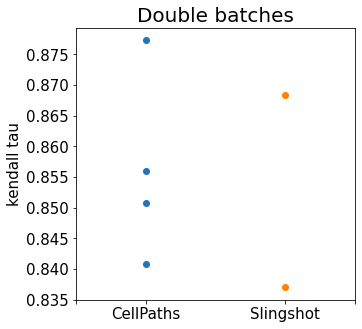

In [17]:
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot()
ax.scatter([0 for x in kt.values()], [x for x in kt.values()])
ax.scatter([1 for x in kt_slingshot.values()], [x for x in kt_slingshot.values()])
ax.set_title("Double batches", fontsize = 20)
ax.set_ylabel("kendall tau", fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)

plt.xticks([-0.5,0,1,1.5],fontsize = 15)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = ""
labels[1] = "CellPaths"
labels[2] = "Slingshot"
labels[3] = ""
ax.set_xticklabels(labels)

# fig.savefig("./sim_results/Dyngen/DoubleBatches/quantity/boxplot.pdf", bbox_inches = "tight")

In [21]:
f1_slingshot = bmk.f1_score(adata = adata, method="Slingshot", slingshot_result = results, trajs = None)

recovery

inferred trajectory: 0 jaccard: 0.23354037267080746
inferred trajectory: 1 jaccard: 0.1832176275279203
recovery value: 0.2083790000993639
relevence

ori trajectory: 1 jaccard: 0.1124223602484472
ori trajectory: 2 jaccard: 0.1832176275279203
ori trajectory: 3 jaccard: 0.1093167701863354
ori trajectory: 4 jaccard: 0.23354037267080746
ori trajectory: 5 jaccard: 0.13552425665101722
ori trajectory: 6 jaccard: 0.1186335403726708
ori trajectory: 8 jaccard: 0.17329990598558445
ori trajectory: 10 jaccard: 0.13569413976809777
relevence value: 0.15020612167636008


In [22]:
bmk_belongings = bmk.purity_count(adata = adata, method = "Slingshot", slingshot_result = results, trajs = None)
entro_slingshot = bmk.average_entropy(bmk_belongings)
entro_slingshot

2.013838090127918

## Trajectory assignment result

In [23]:
print("f1 score of cellpath: " + str(f1) + ", f1 score of slingshot: " + str(f1_slingshot))

f1 score of cellpath: 0.17819114768613697, f1 score of slingshot: 0.17457389915524532


In [24]:
print("Average entropy of cellpath: " + str(entro) + ", Average antropy of slingshot: " + str(entro_slingshot))

Average entropy of cellpath: 1.9652354248454145, Average antropy of slingshot: 2.013838090127918
